In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# col = ["scheduled_off","full_description","competition","competition_type","event_name",
# "team1","team2","1","x","2","vol_1","vol_x","vol_2","bet_1","bet_x","bet_2","favorite_odd","favorite_flag","winner","IP_1","IP_x",
# "IP_2","min_from_start_1","min_from_start_x","min_from_start_2","vm_ep_1","vm_ep_x","vm_ep_2","prob_1","prob_x","prob_2","pnl_1","pnl_x","pnl_2"]
# types = [str, str, str, str, str, str, str, float, float, float, float, float ,float, float, 
#          float, float, float ,str, str, str, str, str, float, float, float,  float, float, float]
# types = {col:t for col, t in zip(col, types)}

# Data file needs to be in xlsx format
data = pd.read_excel("RawData_FootballDataCoUk_DE_EN_ES_FR_NL_BE_IT_PT_GR - Copie.xlsx", header = 0, index_col = 0, encoding = "cp1252", sep = ",", na_values = ["\\N"])
# 'BbAv<2.5'
# 'BbAv>2.5'
data = data.drop(['Bb1X2','BbMxH','BbAvH','BbMxD','BbAvD','BbMxA','BbAvA','MaxH','MaxD','MaxA','AvgH','AvgD','AvgA','BbOU','BbMx>2.5','BbMx<2.5','BbAH','BbAHh','BbMxAHH','BbAvAHH','BbMxAHA','BbAvAHA','GBAHH','GBAHA','GBAH','LBAHH','LBAHA','LBAH','B365AHH','B365AHA','B365AH'],axis=1)

data = data.reset_index()
print(data)

            Date  Country       Competition     HomeTeam     AwayTeam  FTHG  \
0     2000-08-12  Belgium    Jupiler League      Beveren    Charleroi   1.0   
1     2000-08-12  Belgium    Jupiler League     Mechelen         Genk   0.0   
2     2000-08-12  Belgium    Jupiler League  Louvieroise      Lokeren   0.0   
3     2000-08-12  Belgium    Jupiler League     Mouscron     Germinal   3.0   
4     2000-08-12  Belgium    Jupiler League     Westerlo      Antwerp   2.0   
5     2000-08-13  Belgium    Jupiler League        Aalst       Lierse   1.0   
6     2000-08-13  Belgium    Jupiler League  Club Brugge         Gent   6.0   
7     2000-08-13  Belgium    Jupiler League    Harelbeke     Standard   3.0   
8     2000-08-13  Belgium    Jupiler League   St Truiden   Anderlecht   0.0   
9     2000-08-19  Belgium    Jupiler League         Gent     Mechelen   2.0   
10    2000-08-19  Belgium    Jupiler League   Anderlecht     Westerlo   3.0   
11    2000-08-19  Belgium    Jupiler League      Ant

In [46]:
data.to_csv('RawData_FootballDataCoUk_DE_EN_ES_FR_NL_BE_IT_PT_GR - clean.csv')

In [47]:
# data["execution_times"] = np.abs(data["min_from_start_1"].fillna(300) - data["min_from_start_2"].fillna(600)) \
#                         + np.abs(data["min_from_start_1"].fillna(300) - data["min_from_start_x"].fillna(600)) \
#                         + np.abs(data["min_from_start_2"].fillna(300) - data["min_from_start_x"].fillna(600))
# data["execution_times"] = data["execution_times"]
# 
# data["prob_1"] = 1/ data["1"]
# data["prob_x"] = 1/ data["x"]
# data["prob_2"] = 1/ data["2"]
# data["sum_prob"] = data["prob_1"]+data["prob_x"]+data["prob_2"]
# data["1"] = data["1"] * data["sum_prob"]
# data["2"] = data["2"] * data["sum_prob"]
# data["x"] = data["x"] * data["sum_prob"]

# Get columns which contain H, D or A as last character
cols_H = [c for c in data.columns if c[-1] == 'H']
cols_D = [c for c in data.columns if c[-1] == 'D']
cols_A = [c for c in data.columns if c[-1] == 'A']

# Compute an average of all H odds, D odds and A odds to avoid arbitrage (i.e. when sum(1/odd_i) < 1)
data['H_MatchOdds'] = data[cols_H].min(axis=1)
data['D_MatchOdds'] = data[cols_D].min(axis=1)
data['A_MatchOdds'] = data[cols_A].min(axis=1)

# Remove rows where no odds are available
data = data[data['H_MatchOdds'].isnull()==False]
data = data[data['D_MatchOdds'].isnull()==False]
data = data[data['A_MatchOdds'].isnull()==False]

# Arbitrage Calculation
data['sum_prob'] = (1 / data[['H_MatchOdds','D_MatchOdds','A_MatchOdds']]).sum(axis=1)

# Rename columns to 1,x,2 - generate winner - create team1 and team2
data = data.rename(columns = {'H_MatchOdds':'1','D_MatchOdds':'x','A_MatchOdds':'2','HomeTeam':'team1','AwayTeam':'team2'})
data['winner'] = data['FTR'].replace({'H':'1','D':'x','A':'2'})

# Test Odds consistancy Arbitrage, NaN, Inf
#print(data[data['sum_prob']<0.1])

print(data.head())

        Date  Country     Competition        team1      team2  FTHG  FTAG FTR  \
0 2000-08-12  Belgium  Jupiler League      Beveren  Charleroi   1.0   2.0   A   
1 2000-08-12  Belgium  Jupiler League     Mechelen       Genk   0.0   0.0   D   
2 2000-08-12  Belgium  Jupiler League  Louvieroise    Lokeren   0.0   0.0   D   
3 2000-08-12  Belgium  Jupiler League     Mouscron   Germinal   3.0   0.0   H   
4 2000-08-12  Belgium  Jupiler League     Westerlo    Antwerp   2.0   1.0   H   

   HTHG  HTAG   ...   PSCD  PSCA PSH  PSD  PSA     1    x     2  sum_prob  \
0   1.0   1.0   ...    NaN   NaN NaN  NaN  NaN  2.00  3.0  2.50  1.233333   
1   0.0   0.0   ...    NaN   NaN NaN  NaN  NaN  2.00  3.0  2.40  1.250000   
2   0.0   0.0   ...    NaN   NaN NaN  NaN  NaN  2.30  3.0  2.35  1.193648   
3   1.0   0.0   ...    NaN   NaN NaN  NaN  NaN  1.80  3.0  3.50  1.174603   
4   1.0   0.0   ...    NaN   NaN NaN  NaN  NaN  1.41  3.1  3.60  1.309578   

   winner  
0       2  
1       x  
2       x  
3 

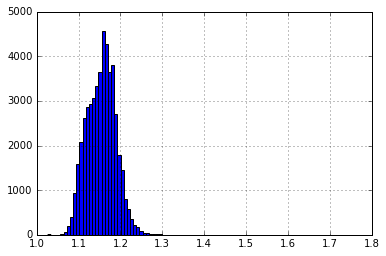

count    48379.000000
mean         1.153884
std          0.034543
min          1.026558
25%          1.128022
50%          1.155807
75%          1.177778
max          1.781979
Name: sum_prob, dtype: float64

In [48]:
# Plot 'sum prob' distribution to check no arbitrage (no data <1)
data["sum_prob"].hist(bins=100)
plt.show()
data["sum_prob"].describe()

In [49]:
def pnl_per_runner(data, fee = 0.0, stake = 10, odds_ratio = 1):
    data = data.copy()
    targets = ["1","x","2"]
    for target in targets:
        pls = []
        for i, odds in data.iterrows():
                pl = ((float(odds[target]) * odds_ratio - 1) * stake) * (1 - fee) if target == odds["winner"] else -stake 
                pls.append(pl)

        data["pnl_"+target] = pls
    return data

data = pnl_per_runner(data)

In [50]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import joblib

data_preprocessing = data[["team1","team2","1","x","2","pnl_1","pnl_x","pnl_2", "winner"]]
data_preprocessing = data_preprocessing[data_preprocessing.astype(str) != "\\N"].dropna().copy()
all_teams = list(data_preprocessing["team1"].values) + list(data_preprocessing["team2"].values) 
le = LabelEncoder()
le.fit(all_teams)

# joblib.dump(le, 'encoder.pkl') 
print("saved model to encoder.pkl")

data_preprocessing["team1_label"] = le.transform(data_preprocessing["team1"])
data_preprocessing["team2_label"] = le.transform(data_preprocessing["team2"])

data_preprocessing["1"] = data_preprocessing["1"].astype(float)
data_preprocessing["x"] = data_preprocessing["x"].astype(float)
data_preprocessing["2"] = data_preprocessing["2"].astype(float)

data_preprocessing["prob_1"] = 1/data_preprocessing["1"]
data_preprocessing["prob_x"] = 1/data_preprocessing["x"]
data_preprocessing["prob_2"] = 1/data_preprocessing["2"]



saved model to encoder.pkl


In [51]:
number_games = len(data_preprocessing)

fit_span = [0 , round(number_games * 0.4)]
cv_span = [round(number_games * 0.4) , round(number_games * 0.7)]
out_span = [round(number_games * 0.7) , number_games]
data_fit = data_preprocessing.iloc[fit_span[0]:fit_span[1]].copy()
data_cv = data_preprocessing.iloc[cv_span[0]:cv_span[1]].copy()
data_out = data_preprocessing.iloc[out_span[0]:out_span[1]].copy()

from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import metrics
from sklearn.externals import joblib
clf = RandomForestRegressor(max_depth=5, n_estimators=20, max_features=5, random_state = 1)
predictors = ["team1_label","team2_label","1", "x", "2"]

#clf = linear_model.LinearRegression()
#predictors = ["1", "x", "2"]


def prediction(data_fit, data_out, target, clf, predictors, save = None):
    X = data_fit[predictors]
    Y = data_fit[target]
    #Y = data_fit["winner"] == "x"
    X_out = data_out[predictors]
    Y_out = data_out[target]
    #clf = RandomForestClassifier(max_depth=10, n_estimators=20, max_features=3)
    
    clf.fit(X,Y)
    Y_estim = clf.predict(X)
    Y_pred = clf.predict(X_out)
    
    print("absolute error of fit")
    print(metrics.mean_absolute_error(Y_estim, Y))
    print("absolute error of pred")
    print(metrics.mean_absolute_error(Y_pred, Y_out))
    print("r2 of fit")
    print(metrics.r2_score(Y_estim, Y))
    print("r2 of pred")
    print(metrics.r2_score(Y_pred, Y_out))
    
    if save is not None:
        joblib.dump(clf, save+'.pkl') 
        print("saved model to "+save+".pkl")
        
    return Y_pred

data_cv["pred_1"] = prediction(data_fit, data_cv, "pnl_1", clf, predictors, save = "predictor_1")
data_cv["pred_x"] = prediction(data_fit, data_cv, "pnl_x", clf, predictors, save = "predictor_x")
data_cv["pred_2"] = prediction(data_fit, data_cv, "pnl_2", clf, predictors, save = "predictor_2")


data_fit["pred_1"] = prediction(data_fit, data_fit, "pnl_1", clf, predictors)
data_fit["pred_x"] = prediction(data_fit, data_fit, "pnl_x", clf, predictors)
data_fit["pred_2"] = prediction(data_fit, data_fit, "pnl_2", clf, predictors)


data_out["pred_1"] = prediction(data_fit, data_out, "pnl_1", clf, predictors)
data_out["pred_x"] = prediction(data_fit, data_out, "pnl_x", clf, predictors)
data_out["pred_2"] = prediction(data_fit, data_out, "pnl_2", clf, predictors)


absolute error of fit
8.92206112836
absolute error of pred
9.35234475657
r2 of fit
-25.7936387621
r2 of pred
-24.8379561166
saved model to predictor_1.pkl
absolute error of fit
11.7381388749
absolute error of pred
12.3344954022
r2 of fit
-39.478257163
r2 of pred
-43.9668019521
saved model to predictor_x.pkl
absolute error of fit
10.4454709995
absolute error of pred
11.0048237045
r2 of fit
-18.6226314269
r2 of pred
-24.4679824003
saved model to predictor_2.pkl
absolute error of fit
8.92206112836
absolute error of pred
8.92206112836
r2 of fit
-25.7936387621
r2 of pred
-25.7936387621
absolute error of fit
11.7381388749
absolute error of pred
11.7381388749
r2 of fit
-39.478257163
r2 of pred
-39.478257163
absolute error of fit
10.4454709995
absolute error of pred
10.4454709995
r2 of fit
-18.6226314269
r2 of pred
-18.6226314269
absolute error of fit
8.92206112836
absolute error of pred
9.26532866575
r2 of fit
-25.7936387621
r2 of pred
-27.5182784757
absolute error of fit
11.7381388749
absolu

In [52]:
def pnl_target(pred, fee = 0.05, stake = 10, max_odds = 2, min_odds = 1.2, 
               scale_with_pred = True, scale_with_odds = False, target_restrict = None,
              min_pred = 0):
    data = pred.copy()
    pls = []
    targets = []
    runners  = ["1","x","2"]
    for i, odds in data.iterrows():
        target = "1"
        for r in runners:
            if float(odds["pred_"+r]) > float(odds["pred_"+target]):
                target = r
        
        restricted = target_restrict is None or target in target_restrict
        
        if odds["pred_"+target] > min_pred and float(odds[target])<max_odds  and float(odds[target])>min_odds and restricted:
            stake_adjusted = stake
            
            if scale_with_odds:
                stake_adjusted = stake_adjusted / float(odds[target])
            
            if scale_with_pred:
                stake_adjusted = stake_adjusted * max(min(odds["pred_"+target], 5), 0.5)
                
            pl = ((float(odds[target]) - 1) * stake_adjusted) * (1 - fee) if target == odds["winner"] else - stake_adjusted 
            pls.append(pl)
            targets.append(target)
        else:
            pls.append(0)
            targets.append(target)
    data["pnl"] = pls
    
    data["bet"] = targets
    data.index = range(len(data))
    data["cum_pnl"] = data["pnl"].cumsum()
    data["drawdown"] = data["cum_pnl"].cummax() - data["cum_pnl"]
    m = (data[data["pnl"] != 0])["pnl"].mean()
    s = (data[data["pnl"] != 0])["pnl"].std()
    
    p_bet = (data[data["pnl"] > 0])["pnl"].count()
    n_bet = (data[data["pnl"] < 0])["pnl"].count()
    
    winning_ratio = p_bet / (p_bet + n_bet)
    print("played games: %f" % (len(data[data["pnl"] != 0]) / len(data)))
    sharpe = m/s
    print("mean : %f" % m)
    print("standard deviation: %f" % s)
    print("max drawdown: %f" % data["drawdown"].max())
    print("winning ratio: %f" % winning_ratio)
    print("sharpe: %f" % (sharpe * np.sqrt(100)))
    return data

In [53]:
pl = pnl_target(data_fit, max_odds = 4, min_odds = 1.1, fee = 0.05, 
                target_restrict = None, scale_with_pred = True, 
                stake = 10, scale_with_odds = False, min_pred = 0.5)

played games: 0.136730
mean : 24.481779
standard deviation: 31.752757
max drawdown: 84.398013
winning ratio: 0.817460
sharpe: 7.710127


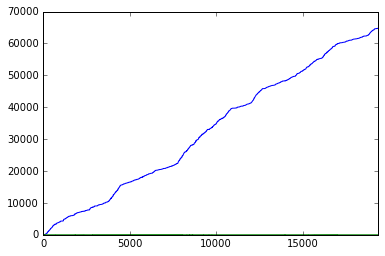

In [54]:
from matplotlib import pyplot as plt
pl["cum_pnl"].plot()
pl["drawdown"].plot()
plt.show()

In [55]:
pl = pnl_target(data_out, max_odds = 4, min_odds = 1.1, fee = 0.1, 
                target_restrict = None, scale_with_pred = True, 
                stake = 40, scale_with_odds = False, min_pred = 0.5)

played games: 0.163015
mean : -11.560334
standard deviation: 114.963510
max drawdown: 27542.810285
winning ratio: 0.327134
sharpe: -1.005566


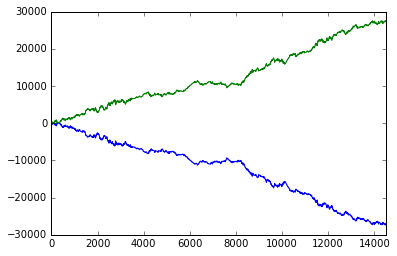

In [56]:
from matplotlib import pyplot as plt
pl["cum_pnl"].plot()
pl["drawdown"].plot()
plt.show()

In [13]:
pl.to_csv("pred_1.csv", sep = ";")

In [305]:
len(data_preprocessing)

137026

In [86]:
from sklearn.externals import joblib

class RFRPredictor():
    def __init__(self, pred_file, encoder_file, runners, stake = 4, target_restrict = None, 
                 scale_with_pred=None, scale_with_odds=None, min_odds = 1.01, 
                 max_odds = 1000, min_pred = 0):
        
        self.encoder_file = encoder_file
        self.pred_file = pred_file
        self.runners = runners
        self.stake = stake
        self.target_restrict = target_restrict
        self.scale_with_pred = scale_with_pred,
        self.scale_with_odds = scale_with_odds, 
        self.min_odds = min_odds
        self.max_odds = max_odds
        self.min_pred = min_pred
        self.models = self.read_models(self.pred_file, self.runners)
        self.encoder = self.read_encoder(self.encoder_file)
        
    def read_models(self, file, runners):
        models = {}
        for runner in runners:
            models[runner] = joblib.load(file+"_"+runner+".pkl")
        return models

    def read_encoder(self, file):
        return joblib.load(file+".pkl")

    def make_prediction(self, data):
        
        try:
            team1_label = self.encoder.transform([data["team1"]])[0]
            team2_label = self.encoder.transform([data["team2"]])[0]
        except ValueError:
            return {runner:-1000 for runner in runners}
        
        regressors = [[team1_label,team2_label,data["1"], data["x"], data["2"]]]
        print(regressors)
        pred = {}

        for runner in self.runners:
            pred[runner] = self.models[runner].predict(regressors)

        return pred

    def get_bet(self, odds):
        
        pred = self.make_prediction(odds)
        print(pred)
        target = self.runners[0]
        for runner in self.runners:
            if float(pred[runner]) > float(pred[target]):
                target = runner

        restricted = self.target_restrict is None or target in self.target_restrict

        if pred[target] > self.min_pred and float(odds[target])<self.max_odds \
                    and float(odds[target])>self.min_odds and restricted:
            
            stake_adjusted = self.stake

            if self.scale_with_odds:
                stake_adjusted = stake_adjusted / float(odds[target])

            if self.scale_with_pred:
                stake_adjusted = stake_adjusted * max(min(pred[target], 5), 0.5)
            return target, stake_adjusted
        else:
            return None, 0


pred_file = "predictor"    
encoder_file = "encoder"
runners = ["1","x","2"]

predictor = RFRPredictor(pred_file, encoder_file, runners, stake = 10, max_odds = 5, min_odds = 1.2, 
        scale_with_pred = True, scale_with_odds = False, target_restrict = None,
        min_pred = 0)

odds = data_preprocessing.iloc[0]

predictor.get_bet(odds)


[[5715, 10146, 2.5, 3.8999999999999999, 5.2000000000000002]]
{'1': array([ 0.38376238]), 'x': array([-0.34452114]), '2': array([-0.33114465])}


('1', 2.0)

In [87]:
print("sharpe: %f" % np.sqrt(100))

sharpe: 10.000000


In [97]:
odds = data_preprocessing.iloc[0]
odds["1"] = 1.5

predictor.get_bet(odds)

[[5715, 10146, 1.5, 3.8999999999999999, 5.2000000000000002]]
{'1': array([-0.71601151]), 'x': array([-0.46854076]), '2': array([-0.43885656])}


c:\users\betfair\anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(None, 0)

In [90]:
odds

team1          Greenbay Hoppers FC
team2                       SAP FC
1                              2.9
x                              3.9
2                              5.2
pnl_1                        14.25
pnl_x                          -10
pnl_2                          -10
winner                           1
team1_label                   5715
team2_label                  10146
prob_1                         0.4
prob_x                     0.25641
prob_2                    0.192308
Name: 70594, dtype: object

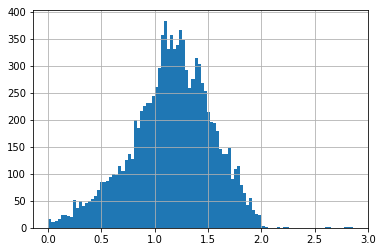

In [161]:
data_preprocessing[["prob_1", "prob_x", "prob_1"]].sum(axis = 1).hist(bins = 100)
plt.show()

In [109]:
data_preprocessing[data_preprocessing[["prob_1", "prob_x", "prob_1"]].sum(axis = 1)<0.1].to_clipboard()

In [110]:
a = (1, 2, 3)

In [111]:
a + (1, 2, 3)

(1, 2, 3, 1, 2, 3)

In [112]:
round(20.5555555,2)

20.56

In [163]:
data.to_clipboard(sep = ";")

In [195]:
len(data_preprocessing)

13293